# Problem definiton
**Segmentation of gliomas in pre-operative MRI scans.**

*Each pixel on image must be labeled:*
* Pixel is part of a tumor area (1 or 2 or 3) -> can be one of multiple classes / sub-regions
* Anything else -> pixel is not on a tumor region (0)

The sub-regions of tumor considered for evaluation are: 1) the "enhancing tumor" (ET), 2) the "tumor core" (TC), and 3) the "whole tumor" (WT)
The provided segmentation labels have values of 1 for NCR & NET, 2 for ED, 4 for ET, and 0 for everything else.



![Brats official annotations](https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/brats-tumor-subregions.jpg)

# Setup env

In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-zc12xhtt
  Running command git clone -q https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-zc12xhtt
  Created wheel for gif-your-nifti: filename=gif_your_nifti-0.2.2-py3-none-any.whl size=6634 sha256=938abad76c16da28dfba1f3b00f2d18d0212db6edbfc19eb0d897acc5ac4904d
  Stored in directory: /tmp/pip-ephem-wheel-cache-nl601zz3/wheels/4a/8c/d1/b228c3b67231f7459e8f70d73f4dadaf65cd90692d41f43e88
Successfully built gif-your-nifti
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

# Image data descriptions

All BraTS multimodal scans are available as  NIfTI files (.nii.gz) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings
1. **T1**: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
2. **T1ce**: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
3. **T2**: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
4. **FLAIR**: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

Data were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.



In [ ]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


**Show whole nifti data -> print each slice from 3d data**

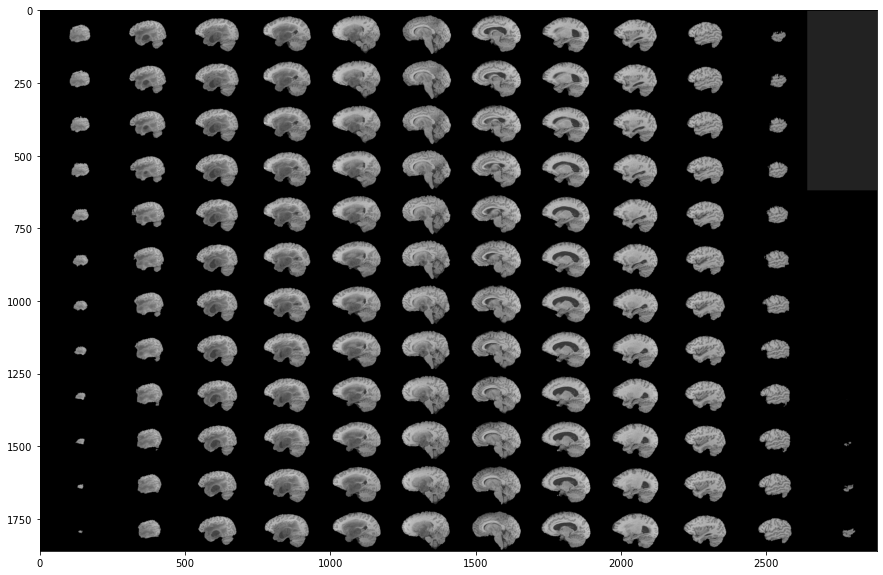

In [ ]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

**Show segment of tumor for each above slice**

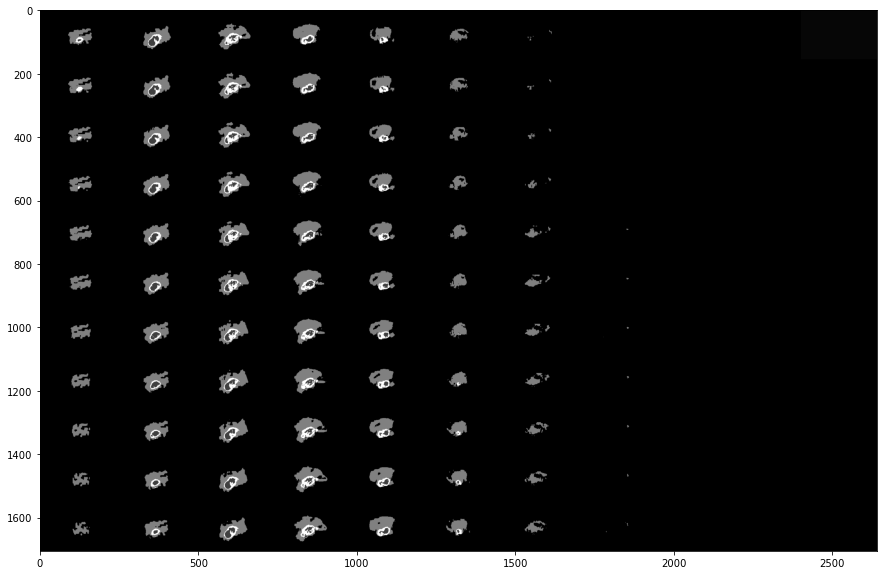

In [ ]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [ ]:
shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')
gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
IMG_SIZE=128

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, SeparableConv2D, Conv2DTranspose, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.metrics import MeanIoU

# --- ECA Attention Block ---
def eca_block(x, k_size=3):
    """
    Efficient Channel Attention (ECA) module.
    """
    # Global average pooling: (B, H, W, C) -> (B, C)
    y = layers.GlobalAveragePooling2D()(x)
    # (B, C) -> (B, C, 1)
    y = layers.Reshape((-1, 1))(y)
    # 1D conv across channels
    y = layers.Conv1D(
        filters=1,
        kernel_size=k_size,
        padding='same',
        use_bias=False
    )(y)
    y = layers.Activation('sigmoid')(y)
    # (B, C, 1) -> (B, 1, 1, C)
    y = layers.Reshape((1, 1, -1))(y)
    # scale
    return layers.Multiply()([x, y])

def sep_conv_block(x, filters, ker_init, dropout_rate=0.0):
    """
    A block of:
      - SeparableConv2D → BN → ReLU
      - SeparableConv2D → BN
      - Optional Dropout
      - Residual add + ReLU
      - ECA attention
    """
    shortcut = x

    # first depthwise‑separable conv
    x = layers.SeparableConv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # second depthwise‑separable conv
    x = layers.SeparableConv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = layers.BatchNormalization()(x)

    # dropout if specified
    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    # project shortcut if needed
    if shortcut.shape[-1] != filters:
        shortcut = layers.SeparableConv2D(filters, 1, padding='same', kernel_initializer=ker_init)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # residual add + activation
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)

    # channel attention
    x = eca_block(x, k_size=3)
    return x


def build_light_unet(input_layer,alpha=0.5, ker_init='he_normal', dropout=0.2):
    f5 = int(512 * alpha)
    # Encoder (Downsampling path)
    # Block 1
    c1 = SeparableConv2D(16, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(input_layer)
    c1 = SeparableConv2D(16, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(c1)
    if dropout:
        c1 = Dropout(dropout)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = SeparableConv2D(32, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(p1)
    c2 = SeparableConv2D(32, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(c2)
    if dropout:
        c2 = Dropout(dropout)(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3
    c3 = SeparableConv2D(64, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(p2)
    c3 = SeparableConv2D(64, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(c3)
    if dropout:
        c3 = Dropout(dropout)(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4
    c4 = SeparableConv2D(128, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(p3)
    c4 = SeparableConv2D(128, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(c4)
    if dropout:
        c4 = Dropout(dropout)(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = sep_conv_block(p4, f5, ker_init, dropout_rate=0.3)

    # Decoder (Upsampling path)
    # Up Block 1
    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])               # skip connection
    c6 = SeparableConv2D(128, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(u6)
    c6 = SeparableConv2D(128, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(c6)
    if dropout:
        c6 = Dropout(dropout)(c6)

    # Up Block 2
    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = SeparableConv2D(64, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(u7)
    c7 = SeparableConv2D(64, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(c7)
    if dropout:
        c7 = Dropout(dropout)(c7)

    # Up Block 3
    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = SeparableConv2D(32, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(u8)
    c8 = SeparableConv2D(32, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(c8)
    if dropout:
        c8 = Dropout(dropout)(c8)

    # Up Block 4
    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = SeparableConv2D(16, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(u9)
    c9 = SeparableConv2D(16, (3,3), activation='relu', padding='same',
                         kernel_initializer=ker_init)(c9)
    if dropout:
        c9 = Dropout(dropout)(c9)

    # Output layer
    outputs = Conv2D(4, (1,1), activation='softmax', padding='same')(c9)
    model = Model(inputs=input_layer, outputs=outputs)
    return model

inputs = Input((IMG_SIZE, IMG_SIZE, 2))
model = build_light_unet(inputs, ker_init='he_normal', dropout=0.2)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4),
                       dice_coef, precision, sensitivity, specificity,
                       dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])
model.summary()

**model architecture** <br>
If you are about to use U-NET, I suggest to check out this awesome library that I found later, after manual implementation of U-NET [keras-unet-collection](https://pypi.org/project/keras-unet-collection/), which also contains implementation of dice loss, tversky loss and many more!

In [ ]:
# plot_model(model,
#            show_shapes = True,
#            show_dtype=False,
#            show_layer_names = True,
#            rankdir = 'TB',
#            expand_nested = False,
#            dpi = 70)

# Load data
Loading all data into memory is not a good idea since the data are too big to fit in.
So we will create dataGenerators - load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [ ]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

**Override Keras sequence DataGenerator class**

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

**Number of data used**
for training / testing / validation

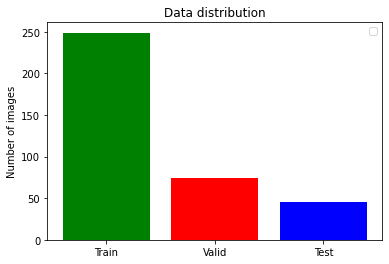

In [ ]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

**Add callback for training process**

In [ ]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

# Train model
My best model was trained with 81% accuracy on mean IOU and 65.5% on Dice loss <br>
I will load this pretrained model instead of training again

In [ ]:
K.clear_session()
# I train by 35 epochs but for time i will use 15 epochs
history =  model.fit(training_generator,
                    epochs=15,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )
model.save("3D_MRI_Brain_tumor_segmentation.h5")

**Visualize the training process**

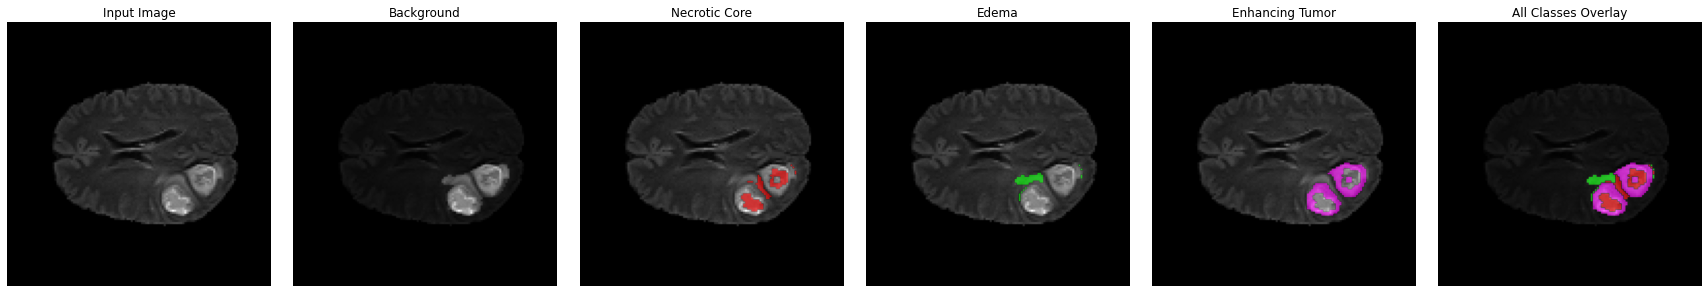

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Existing helper to overlay a color mask

def _overlay_color_mask(ax, mask, color, alpha):
    """
    Overlay a binary mask on ax with given hex color and alpha transparency.
    """
    h, w = mask.shape
    rgba = np.zeros((h, w, 4), dtype=float)
    r, g, b = mcolors.to_rgb(color)
    rgba[..., 0][mask] = r
    rgba[..., 1][mask] = g
    rgba[..., 2][mask] = b
    rgba[..., 3][mask] = alpha
    ax.imshow(rgba)


# Visualization: separate + all classes

def visualize_prediction_separate_with_input(
    input_img,
    prediction,
    class_names=None,
    class_order=None,
    class_colors=None,
    default_cmap='nipy_spectral',
    alpha=0.5
):
    num_classes = int(prediction.max()) + 1
    if class_names is None:
        class_names = [f'Class {i}' for i in range(num_classes)]
    if class_order is None:
        class_order = list(range(num_classes))
    if class_colors is None:
        class_colors = {}

    total = len(class_order) + 2
    fig, axes = plt.subplots(1, total, figsize=(4*total, 4))

    ax = axes[0]
    ax.imshow(input_img, cmap='gray')
    ax.set_title('Input Image')
    ax.axis('off')

    for idx, cls in enumerate(class_order, start=1):
        ax = axes[idx]
        ax.imshow(input_img, cmap='gray')
        mask = prediction == cls
        if cls in class_colors:
            _overlay_color_mask(ax, mask, class_colors[cls], alpha)
        else:
            ax.imshow(np.ma.masked_where(~mask, prediction), cmap=default_cmap, vmin=0, vmax=num_classes-1, alpha=alpha)
        ax.set_title(class_names[cls])
        ax.axis('off')

    ax = axes[-1]
    ax.imshow(input_img, cmap='gray')
    for cls in class_order:
        mask = prediction == cls
        if cls in class_colors:
            _overlay_color_mask(ax, mask, class_colors[cls], alpha)
        else:
            ax.imshow(np.ma.masked_where(~mask, prediction), cmap=default_cmap, vmin=0, vmax=num_classes-1, alpha=alpha)
    ax.set_title('All Classes Overlay')
    ax.axis('off')

    plt.tight_layout()
    plt.show()


# Grid visualization for a range of slices

def visualize_overlay_grid(
    image_paths,
    slice_indices,
    preprocess_fn,
    predict_fn,
    class_names=None,
    class_order=None,
    class_colors=None,
    cmap='nipy_spectral',
    alpha=0.5,
    ncols=5
):
    num_slices = len(slice_indices)
    if class_order is None:
        first_pred = predict_fn(image_paths, slice_indices[0])
        num_classes = int(first_pred.max()) + 1
        class_order = list(range(num_classes))
    if class_names is None:
        class_names = [f'Class {i}' for i in class_order]
    if class_colors is None:
        class_colors = {}

    nrows = (num_slices + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()

    for ax, sl in zip(axes, slice_indices):
        input_img = preprocess_fn(image_paths[0], sl)
        prediction = predict_fn(image_paths, sl)

        ax.imshow(input_img, cmap='gray')
        for cls in class_order:
            mask = prediction == cls
            if cls in class_colors:
                _overlay_color_mask(ax, mask, class_colors[cls], alpha)
            else:
                ax.imshow(np.ma.masked_where(~mask, prediction), cmap=cmap, vmin=0, vmax=int(prediction.max()), alpha=alpha)
        ax.set_title(f'Slice {sl}')
        ax.axis('off')

    for ax in axes[num_slices:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Wrapper to display All Classes Overlay for a slice range

def overlay_range_all_classes(
    image_paths,
    start_slice=20,
    end_slice=150,
    step=1,
    preprocess_fn=None,
    predict_fn=None,
    class_names=None,
    class_order=None,
    class_colors=None,
    cmap='nipy_spectral',
    alpha=0.5,
    ncols=5
):
    if preprocess_fn is None or predict_fn is None:
        raise ValueError('preprocess_fn and predict_fn must be provided')
    slice_indices = list(range(start_slice, end_slice+1, step))
    visualize_overlay_grid(
        image_paths,
        slice_indices,
        preprocess_fn,
        predict_fn,
        class_names=class_names,
        class_order=class_order,
        class_colors=class_colors,
        cmap=cmap,
        alpha=alpha,
        ncols=ncols
    )


# Create GIF animation of overlays

import imageio
import io

def create_overlay_gif(
    image_paths,
    start_slice=20,
    end_slice=150,
    step=1,
    preprocess_fn=None,
    predict_fn=None,
    class_names=None,
    class_order=None,
    class_colors=None,
    cmap='nipy_spectral',
    alpha=0.5,
    duration=0.1,
    output_path='overlay_animation.gif'
):
    if preprocess_fn is None or predict_fn is None:
        raise ValueError('preprocess_fn and predict_fn must be provided')
    slice_indices = list(range(start_slice, end_slice+1, step))
    frames = []
    for sl in slice_indices:
        fig, ax = plt.subplots(figsize=(6,6))
        img = preprocess_fn(image_paths[0], sl)
        pred = predict_fn(image_paths, sl)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        for cls in (class_order if class_order is not None else range(int(pred.max())+1)):
            mask = pred == cls
            if class_colors and cls in class_colors:
                _overlay_color_mask(ax, mask, class_colors[cls], alpha)
            else:
                ax.imshow(np.ma.masked_where(~mask, pred), cmap=cmap, vmin=0, vmax=int(pred.max()), alpha=alpha)
        ax.set_title(f'Slice {sl}')
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape((h, w, 3))
        frames.append(buf)
        plt.close(fig)
    imageio.mimsave(output_path, frames, duration=duration)
    print(f'GIF saved to {output_path}')


# Show GIF in notebook

from IPython.display import Image, display

def show_overlay_gif(path='overlay_animation.gif'):
    display(Image(filename=path))

# == New cell: Single Slice Visualization with consistent colors ==

# Example for slice_index = 85
slice_index = 85
flair_slice = preprocess_image(image_paths[0], slice_index)
prediction_mask = predict(image_paths, slice_index)

# Define consistent colors matching GIF
class_colors = {
    0: '#000000',  # Background: black
    1: '#FF0000',  # Necrotic Core: red
    2: '#00FF00',  # Edema: green
    3: '#FF00FF'   # Enhancing Tumor: magenta
}

visualize_prediction_separate_with_input(
    flair_slice,
    prediction_mask,
    class_names=['Background','Necrotic Core','Edema','Enhancing Tumor'],
    class_order=[0,1,2,3],
    class_colors=class_colors,
    alpha=0.6
)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def _overlay_color_mask(ax, mask, color, alpha):
    """
    Overlay a binary mask on ax with given hex color and alpha transparency.
    """
    h, w = mask.shape
    rgba = np.zeros((h, w, 4), dtype=float)
    r, g, b = mcolors.to_rgb(color)
    rgba[..., 0][mask] = r
    rgba[..., 1][mask] = g
    rgba[..., 2][mask] = b
    rgba[..., 3][mask] = alpha
    ax.imshow(rgba)


def visualize_prediction_separate_with_input(
    input_img,
    prediction,
    class_names=None,
    class_order=None,
    class_colors=None,
    default_cmap='nipy_spectral',
    alpha=0.5
):
    num_classes = int(prediction.max()) + 1
    if class_names is None:
        class_names = [f'Class {i}' for i in range(num_classes)]
    if class_order is None:
        class_order = list(range(num_classes))
    if class_colors is None:
        class_colors = {}

    total = len(class_order) + 2
    fig, axes = plt.subplots(1, total, figsize=(4*total, 4))

    ax = axes[0]
    ax.imshow(input_img, cmap='gray')
    ax.set_title('Input Image')
    ax.axis('off')

    for idx, cls in enumerate(class_order, start=1):
        ax = axes[idx]
        ax.imshow(input_img, cmap='gray')
        mask = prediction == cls
        if cls in class_colors:
            _overlay_color_mask(ax, mask, class_colors[cls], alpha)
        else:
            ax.imshow(np.ma.masked_where(~mask, prediction), cmap=default_cmap, vmin=0, vmax=num_classes-1, alpha=alpha)
        ax.set_title(class_names[cls])
        ax.axis('off')

    ax = axes[-1]
    ax.imshow(input_img, cmap='gray')
    for cls in class_order:
        mask = prediction == cls
        if cls in class_colors:
            _overlay_color_mask(ax, mask, class_colors[cls], alpha)
        else:
            ax.imshow(np.ma.masked_where(~mask, prediction), cmap=default_cmap, vmin=0, vmax=num_classes-1, alpha=alpha)
    ax.set_title('All Classes Overlay')
    ax.axis('off')

    plt.tight_layout()
    plt.show()


def visualize_overlay_grid(
    image_paths,
    slice_indices,
    preprocess_fn,
    predict_fn,
    class_names=None,
    class_order=None,
    class_colors=None,
    cmap='nipy_spectral',
    alpha=0.5,
    ncols=5
):
    num_slices = len(slice_indices)
    if class_order is None:
        first_pred = predict_fn(image_paths, slice_indices[0])
        num_classes = int(first_pred.max()) + 1
        class_order = list(range(num_classes))
    if class_names is None:
        class_names = [f'Class {i}' for i in class_order]
    if class_colors is None:
        class_colors = {}

    nrows = (num_slices + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()

    for ax, sl in zip(axes, slice_indices):
        input_img = preprocess_fn(image_paths[0], sl)
        prediction = predict_fn(image_paths, sl)

        ax.imshow(input_img, cmap='gray')
        for cls in class_order:
            mask = prediction == cls
            if cls in class_colors:
                _overlay_color_mask(ax, mask, class_colors[cls], alpha)
            else:
                ax.imshow(np.ma.masked_where(~mask, prediction), cmap=cmap, vmin=0, vmax=int(prediction.max()), alpha=alpha)
        ax.set_title(f'Slice {sl}')
        ax.axis('off')

    for ax in axes[num_slices:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# == New cell ==

def overlay_range_all_classes(
    image_paths,
    start_slice=20,
    end_slice=150,
    step=1,
    preprocess_fn=None,
    predict_fn=None,
    class_names=None,
    class_order=None,
    class_colors=None,
    cmap='nipy_spectral',
    alpha=0.5,
    ncols=5
):
    if preprocess_fn is None or predict_fn is None:
        raise ValueError('preprocess_fn and predict_fn must be provided')
    slice_indices = list(range(start_slice, end_slice+1, step))
    visualize_overlay_grid(
        image_paths,
        slice_indices,
        preprocess_fn,
        predict_fn,
        class_names=class_names,
        class_order=class_order,
        class_colors=class_colors,
        cmap=cmap,
        alpha=alpha,
        ncols=ncols
    )

# == New cell: Create GIF ==
import imageio
import io

def create_overlay_gif(
    image_paths,
    start_slice=20,
    end_slice=150,
    step=1,
    preprocess_fn=None,
    predict_fn=None,
    class_names=None,
    class_order=None,
    class_colors=None,
    cmap='nipy_spectral',
    alpha=0.5,
    duration=0.1,
    output_path='overlay_animation.gif'
):
    """
    Tạo file GIF animation cho All Classes Overlay qua các slice.
    """
    if preprocess_fn is None or predict_fn is None:
        raise ValueError('preprocess_fn and predict_fn must be provided')
    slice_indices = list(range(start_slice, end_slice+1, step))
    frames = []
    for sl in slice_indices:
        fig, ax = plt.subplots(figsize=(6,6))
        img = preprocess_fn(image_paths[0], sl)
        pred = predict_fn(image_paths, sl)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        for cls in (class_order if class_order is not None else range(int(pred.max())+1)):
            mask = pred == cls
            if class_colors and cls in class_colors:
                _overlay_color_mask(ax, mask, class_colors[cls], alpha)
            else:
                ax.imshow(np.ma.masked_where(~mask, pred), cmap=cmap, vmin=0, vmax=int(pred.max()), alpha=alpha)
        ax.set_title(f'Slice {sl}')
        fig.canvas.draw()
        # convert to array
        w, h = fig.canvas.get_width_height()
        buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape((h, w, 3))
        frames.append(buf)
        plt.close(fig)
    # save GIF
    imageio.mimsave(output_path, frames, duration=duration)
    print(f'GIF saved to {output_path}')

# Example:
create_overlay_gif(
    image_paths,
    start_slice=10,
    end_slice=150,
    step=5,
    preprocess_fn=preprocess_image,
    predict_fn=predict,
    class_names=['Background','Necrotic Core','Edema','Enhancing Tumor'],
    class_order=[0,2,3,1],
    class_colors = {
    0: '#000000',  # Background: black
    1: '#FF0000',  # Necrotic Core: red
    2: '#00FF00',  # Edema: green
    3: '#FF00FF'   # Enhancing Tumor: magenta
},
    alpha=0.6,
    duration=0.2,
    output_path='tumor_overlay.gif'
)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


GIF saved to tumor_overlay.gif


In [ ]:
from IPython.display import Image, display

def show_overlay_gif(path='/kaggle/working/tumor_overlay.gif'):
    """
    Hiển thị GIF đã tạo ngay trong notebook.
    """
    display(Image(filename=path))


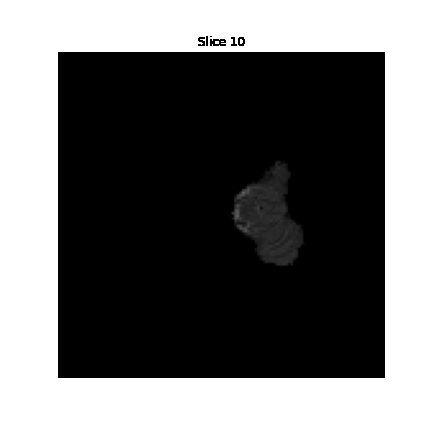

In [ ]:
show_overlay_gif('tumor_overlay.gif')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning:

invalid value encountered in true_divide



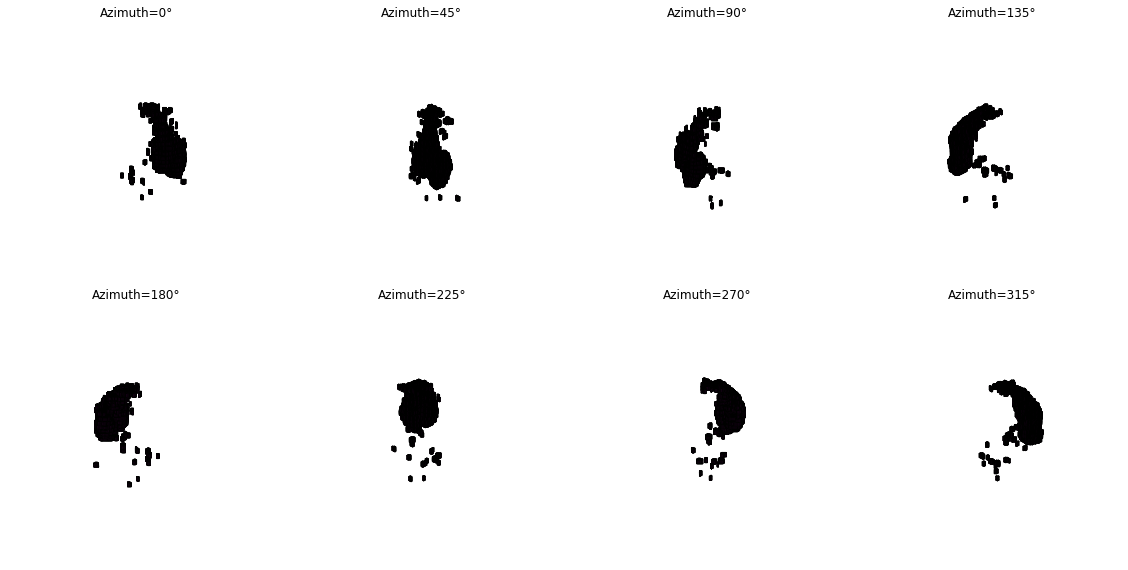

TypeError: render_voxels_multiple_angles() got an unexpected keyword argument 'slice_index'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

# Helper to overlay a color mask
def _overlay_color_mask(ax, mask, color, alpha):
    h, w = mask.shape
    rgba = np.zeros((h, w, 4), dtype=float)
    r, g, b = mcolors.to_rgb(color)
    rgba[..., 0][mask] = r
    rgba[..., 1][mask] = g
    rgba[..., 2][mask] = b
    rgba[..., 3][mask] = alpha
    ax.imshow(rgba)

# 1) Separate + all classes visualization
def visualize_prediction_separate_with_input(
    input_img,
    prediction,
    class_names=None,
    class_order=None,
    class_colors=None,
    default_cmap='nipy_spectral',
    alpha=0.5
):
    num_classes = int(prediction.max()) + 1
    class_names = class_names or [f'Class {i}' for i in range(num_classes)]
    class_order = class_order or list(range(num_classes))
    class_colors = class_colors or {}
    total = len(class_order) + 2
    fig, ax_list = plt.subplots(1, total, figsize=(4*total, 4))
    axes = np.atleast_1d(ax_list)
    axes[0].imshow(input_img, cmap='gray'); axes[0].set_title('Input Image'); axes[0].axis('off')
    for idx, cls in enumerate(class_order, start=1):
        mask = (prediction == cls)
        ax = axes[idx]
        ax.imshow(input_img, cmap='gray')
        if cls in class_colors:
            _overlay_color_mask(ax, mask, class_colors[cls], alpha)
        else:
            ax.imshow(np.ma.masked_where(~mask, prediction), cmap=default_cmap, vmin=0, vmax=num_classes-1, alpha=alpha)
        ax.set_title(class_names[cls]); ax.axis('off')
    ax = axes[-1]
    ax.imshow(input_img, cmap='gray')
    for cls in class_order:
        mask = (prediction == cls)
        if cls in class_colors:
            _overlay_color_mask(ax, mask, class_colors[cls], alpha)
        else:
            ax.imshow(np.ma.masked_where(~mask, prediction), cmap=default_cmap, vmin=0, vmax=num_classes-1, alpha=alpha)
    ax.set_title('All Classes Overlay'); ax.axis('off')
    plt.tight_layout(); plt.show()

# 2) Static 3D voxel rendering using matplotlib (Kaggle friendly)
def render_3d_voxels(
    image_paths,
    preprocess_fn,
    predict_fn,
    start_slice=20,
    end_slice=150,
    step=1,
    class_label=3,
    color='#FF00FF',
    edgecolor='k',
    alpha=0.5
):
    slices = list(range(start_slice, end_slice+1, step))
    vol = np.stack([(predict_fn(image_paths, sl) == class_label) for sl in slices], axis=-1)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    filled = vol.astype(bool)
    facecolors = np.empty(filled.shape + (4,), dtype=float)
    facecolors[...] = mcolors.to_rgba(color, alpha=alpha)
    ax.voxels(filled, facecolors=facecolors, edgecolor=edgecolor)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Slice')
    plt.title(f'3D Voxels for class {class_label}')
    plt.show()

# 3) Generate static plots from multiple angles
#    Renders the voxel plot at different azimuth angles in a grid
def render_voxels_multiple_angles(
    image_paths,
    preprocess_fn,
    predict_fn,
    start_slice=20,
    end_slice=150,
    step=1,
    class_label=3,
    color='#FF00FF',
    edgecolor='k',
    alpha=0.5,
    angles=None,
    ncols=4
):
    """
    Renders a 3D voxel model for specified class across multiple slices
    from various azimuth angles in a grid.

    Parameters
    ----------
    image_paths : list[str] input modalities
    preprocess_fn : function to load & preprocess
    predict_fn : function to predict mask
    start_slice, end_slice, step : define slice range
    class_label : int label to render
    color : hex for facecolor
    edgecolor : edge color
    alpha : transparency
    angles : list of azimuth angles
    ncols : number of columns in subplot grid
    """
    # Build 3D boolean volume for class_label
    slice_indices = list(range(start_slice, end_slice+1, step))
    volume = np.stack(
        [(predict_fn(image_paths, sl) == class_label) for sl in slice_indices],
        axis=-1
    )

    # Default viewing angles
    angles = angles or [0, 90, 180, 270]
    n = len(angles)
    rows = (n + ncols - 1) // ncols

    fig = plt.figure(figsize=(4 * ncols, 4 * rows))
    for idx, az in enumerate(angles):
        ax = fig.add_subplot(rows, ncols, idx+1, projection='3d')
        # Prepare facecolors array
        fc = np.zeros(volume.shape + (4,), dtype=float)
        rgba = mcolors.to_rgba(color, alpha=alpha)
        fc[..., :] = rgba
        ax.voxels(volume, facecolors=fc, edgecolor=edgecolor)
        ax.view_init(elev=30, azim=az)
        ax.set_title(f'Azimuth={az}°')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
render_voxels_multiple_angles(
    image_paths,
    preprocess_image,
    predict,
    start_slice=20,
    end_slice=150,
    step=5,
    class_label=3,
    angles=[0,45,90,135,180,225,270,315],
    ncols=4
)
render_voxels_multiple_angles(
    image_paths,
    preprocess_image,
    predict,
    slice_index=85,
    angles=[0,45,90,135,180,225,270,315],
    class_label=3,
    ncols=4
)
render_voxels_with_depth_shading(
    image_paths,
    predict,
    slice_index=85,
    depth_layers=10,
    colormap='cool',
    alpha=0.9,
    angles=[0,90,180],
    ncols=3
)

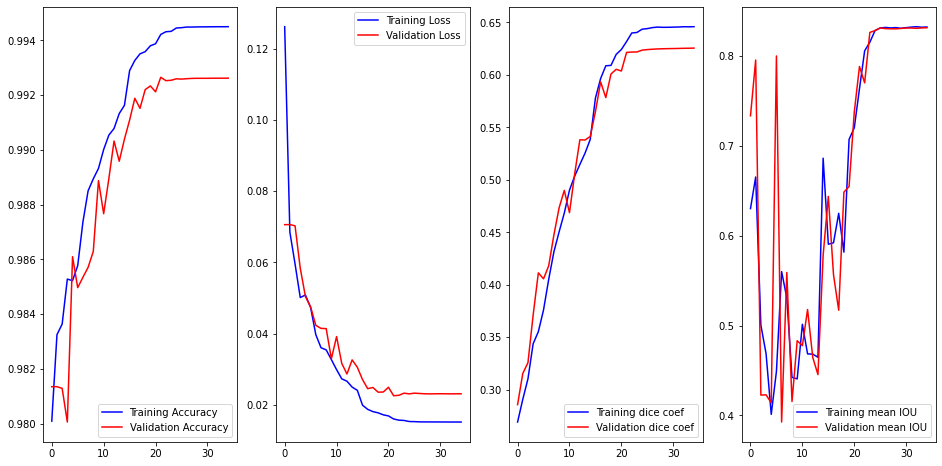

In [ ]:
############ load trained model ################
model = keras.models.load_model('../input/modelperclasseval/model_per_class.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('../input/modelperclasseval/training_per_class.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

# Prediction examples

In [ ]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

4/4 [==============================] - 0s 36ms/step


<Figure size 1296x3600 with 0 Axes>

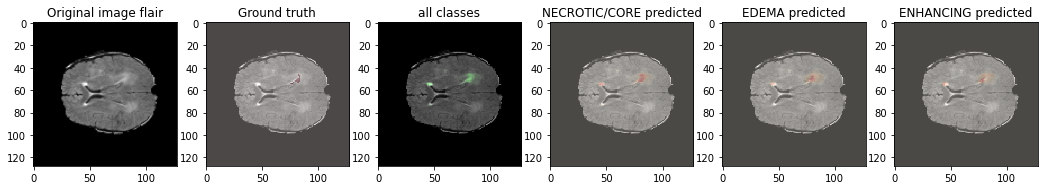

4/4 [==============================] - 0s 34ms/step


<Figure size 1296x3600 with 0 Axes>

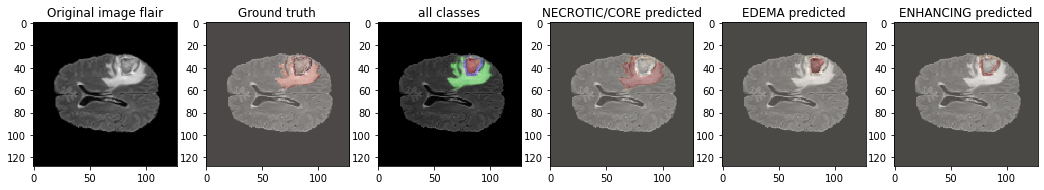

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

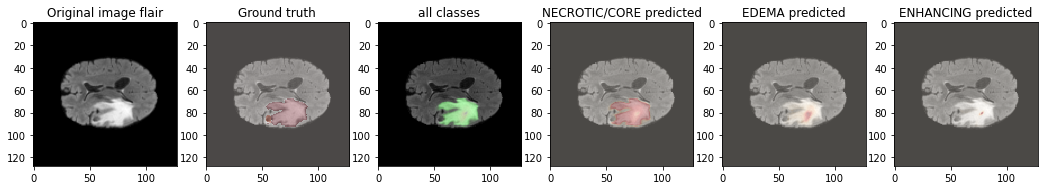

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

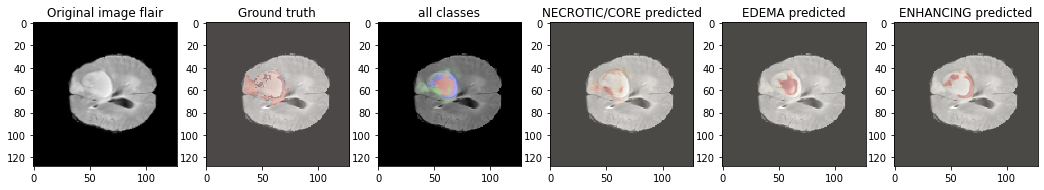

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

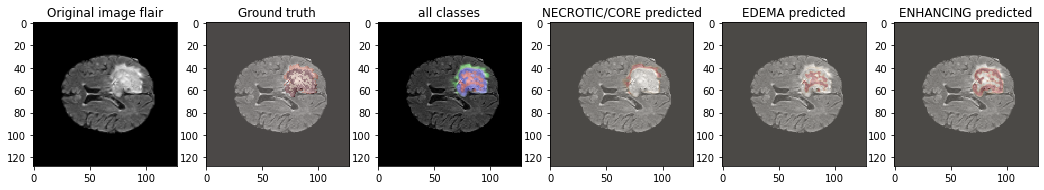

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

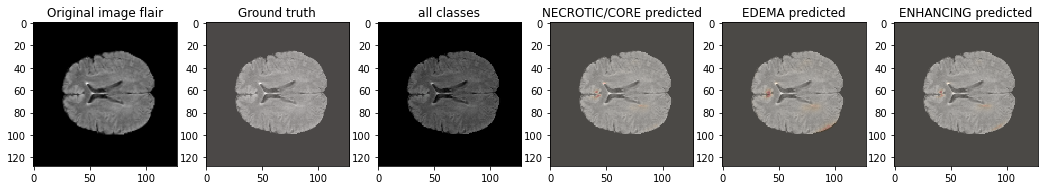

4/4 [==============================] - 0s 33ms/step


<Figure size 1296x3600 with 0 Axes>

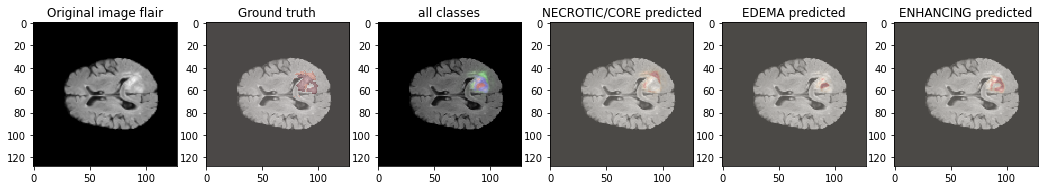

In [ ]:


def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()

 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])


# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()

In [ ]:
def showPredictsById(case, slices=[60, 70, 80, 90, 100, 110]):
    """
    case:   string, ví dụ '010'
    slices: list các chỉ số slice bạn muốn show
    """
    # Đường dẫn tới case
    path      = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    # Load GT và FLAIR volume
    gt_vol    = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    flair_vol = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    # Predict toàn volume
    p = predictByPath(path, case)   # (N, H, W, 4) raw softmax

    # Các class probs
    core     = p[...,1]
    edema    = p[...,2]
    enhancing= p[...,3]

    # Chuẩn bị figure có len(slices) cột
    n = len(slices)
    fig, axarr = plt.subplots(1, n, figsize=(4*n, 4))

    for ax, sl in zip(axarr, slices):
        # 1) input slice (FLAIR)
        img = cv2.resize(flair_vol[:,:,sl+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Slice {sl}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Bây giờ show details cho từng slice: GT, all classes, per-class
    for sl in slices:
        fig, axs = plt.subplots(1, 6, figsize=(24,4))

        # Original
        img = cv2.resize(flair_vol[:,:,sl+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        axs[0].imshow(img, cmap="gray"); axs[0].set_title('FLAIR'); axs[0].axis('off')

        # Ground truth
        gt_sl = cv2.resize(gt_vol[:,:,sl+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        axs[1].imshow(img, cmap="gray")
        axs[1].imshow(gt_sl, alpha=0.3, cmap="Reds", vmin=0, vmax=3)
        axs[1].set_title('Ground truth'); axs[1].axis('off')

        # All classes overlay
        full_mask = np.argmax(p, axis=-1)[sl]
        axs[2].imshow(img, cmap="gray")
        axs[2].imshow(full_mask, alpha=0.3, cmap="tab10", vmin=0, vmax=3)
        axs[2].set_title('All classes'); axs[2].axis('off')

        # Edema
        axs[3].imshow(img, cmap="gray")
        axs[3].imshow(edema[sl], alpha=0.3, cmap="OrRd")
        axs[3].set_title('Edema'); axs[3].axis('off')

        # Core
        axs[4].imshow(img, cmap="gray")
        axs[4].imshow(core[sl], alpha=0.3, cmap="OrRd")
        axs[4].set_title('Core'); axs[4].axis('off')

        # Enhancing
        axs[5].imshow(img, cmap="gray")
        axs[5].imshow(enhancing[sl], alpha=0.3, cmap="OrRd")
        axs[5].set_title('Enhancing'); axs[5].axis('off')

        plt.tight_layout()
        plt.show()


# Evaluation

4/4 [==============================] - 0s 36ms/step


<Figure size 432x288 with 0 Axes>

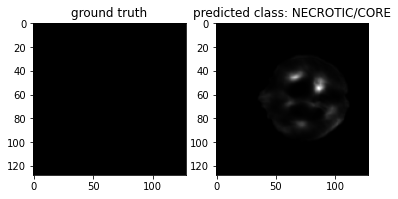

In [ ]:
case = case=test_ids[3][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 1 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

4/4 [==============================] - 0s 35ms/step


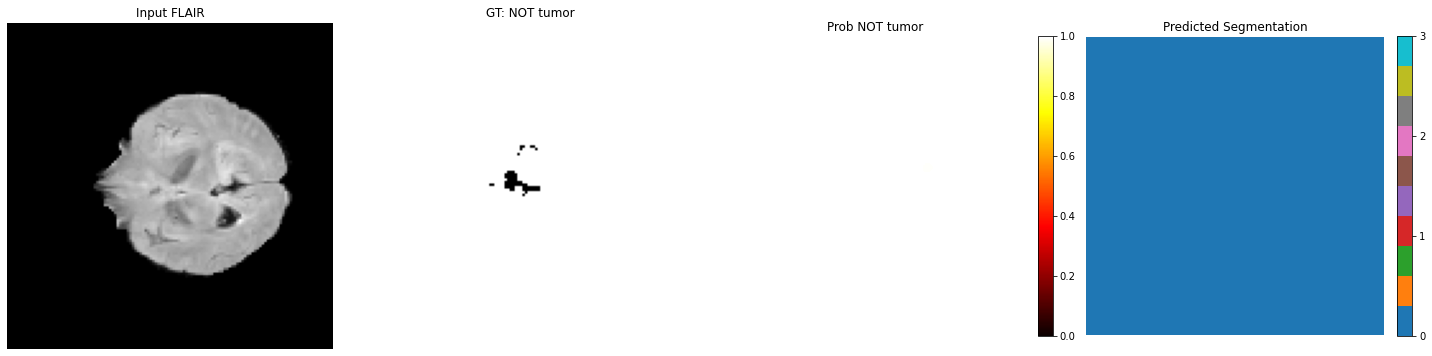

In [ ]:
import os
import cv2
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# --- load data giống như bạn làm ---
case = test_ids[3][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"

# volume GT và input FLAIR
gt_vol    = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
flair_vol = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()

# predictByPath trả về raw softmax probs
p = predictByPath(path, case)  # shape = (N, H, W, 4)

# segmentation mask multi‑class
seg_mask = np.argmax(p, axis=-1)  # shape = (N, H, W)

# chọn slice và class để visualize
i = 40
eval_class = 0   # 0: NOT tumor, 1: ENHANCING, 2: CORE, 3: WHOLE

# --- chuẩn bị từng panel ---
# 1) input FLAIR slice
slice_img = cv2.resize(
    flair_vol[:, :, i + VOLUME_START_AT],
    (IMG_SIZE, IMG_SIZE),
    interpolation=cv2.INTER_LINEAR
)

# 2) ground‑truth binary mask cho eval_class
binary_gt = (gt_vol[:, :, i + VOLUME_START_AT] == eval_class).astype(np.uint8)
gt_mask   = cv2.resize(
    binary_gt,
    (IMG_SIZE, IMG_SIZE),
    interpolation=cv2.INTER_NEAREST
)

# 3) probabilty map cho eval_class
prob_map  = p[i, :, :, eval_class]

# 4) full predicted segmentation (multi‑class)
full_seg_mask = seg_mask[i]

# --- vẽ 4 panel ---
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(slice_img, cmap='gray')
axes[0].set_title("Input FLAIR")
axes[0].axis('off')

axes[1].imshow(gt_mask, cmap='gray')
axes[1].set_title(f"GT: {SEGMENT_CLASSES[eval_class]}")
axes[1].axis('off')

im = axes[2].imshow(prob_map, cmap='hot', vmin=0, vmax=1)
axes[2].set_title(f"Prob {SEGMENT_CLASSES[eval_class]}")
axes[2].axis('off')
fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

im2 = axes[3].imshow(full_seg_mask, cmap='tab10', vmin=0, vmax=3)
axes[3].set_title("Predicted Segmentation")
axes[3].axis('off')
cbar = fig.colorbar(im2, ax=axes[3], ticks=[0,1,2,3], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(SEGMENT_CLASSES)

plt.tight_layout()
plt.show()


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
45/45 [==============================] - 29s 620ms/step - loss: 0.0178 - accuracy: 0.9939 - mean_io_u_1: 0.8283 - dice_coef: 0.6307 - precision: 0.9943 - sensitivity: 0.9924 - specificity: 0.9981 - dice_coef_necrotic: 0.5886 - dice_coef_edema: 0.7780 - dice_coef_enhancing: 0.7247
test loss, test acc: [0.018795911222696304, 0.9936781525611877, 0.8289465308189392, 0.6197661757469177, 0.9940294623374939, 0.9922806024551392, 0.9979825615882874, 0.5869367718696594, 0.7548051476478577, 0.6657092571258545]
